In [1]:
!pip install -q torch 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio

In [3]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
to_image = transforms.ToPILImage()
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

device = 'cuda'

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [5]:
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

def noise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [6]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    error_real = criterion(prediction_real, make_ones(n))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = criterion(prediction_fake, make_zeros(n))
    
    error_fake.backward()
    optimizer.step()
    
    return error_real + error_fake

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    error = criterion(prediction, make_ones(n))
    
    error.backward()
    optimizer.step()
    
    return error

In [ ]:
num_epochs = 100
k = 1
test_noise = noise(64)

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    g_error = 0.0
    d_error = 0.0
    for i, data in enumerate(trainloader):
        imgs, _ = data
        n = len(imgs)
        for j in range(k):
            fake_data = generator(noise(n)).detach()
            real_data = imgs.to(device)
            d_error += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise(n))
        g_error += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_error/i)
    d_losses.append(d_error/i)
    print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_error/i, d_error/i))
    
print('Training Finished')
torch.save(generator.state_dict(), 'mnist_generator.pth')

Epoch 0: g_loss: 6.08785057 d_loss: 0.53766435
Epoch 1: g_loss: 2.79031420 d_loss: 0.80482000
Epoch 2: g_loss: 3.37120748 d_loss: 0.37152535
Epoch 3: g_loss: 4.32078409 d_loss: 0.32687140
Epoch 4: g_loss: 3.26340389 d_loss: 0.45716834
Epoch 5: g_loss: 3.03796172 d_loss: 0.53229046
Epoch 6: g_loss: 2.87908268 d_loss: 0.50870705
Epoch 7: g_loss: 2.45447755 d_loss: 0.62449521
Epoch 8: g_loss: 2.34629440 d_loss: 0.63928270
Epoch 9: g_loss: 2.33120537 d_loss: 0.65795052
Epoch 10: g_loss: 2.17776060 d_loss: 0.72578311
Epoch 11: g_loss: 1.95222318 d_loss: 0.78042889
Epoch 12: g_loss: 1.98217952 d_loss: 0.74511373
Epoch 13: g_loss: 2.03345084 d_loss: 0.78001738
Epoch 14: g_loss: 1.90921021 d_loss: 0.79240537
Epoch 15: g_loss: 1.79535079 d_loss: 0.82860696
Epoch 16: g_loss: 1.74099624 d_loss: 0.86568648
Epoch 17: g_loss: 1.68247688 d_loss: 0.87147260
Epoch 18: g_loss: 1.65425909 d_loss: 0.90027392
Epoch 19: g_loss: 1.67993462 d_loss: 0.87617940
Epoch 20: g_loss: 1.55265999 d_loss: 0.93096626
Ep

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('progress.gif', imgs)
print(g_losses)
print(g_losses[0].eval())
#plt.plot(g_losses, label='Generator_Losses')
#plt.plot(d_losses, label='Discriminator Losses')
#plt.legend()
#plt.savefig('loss.png')

In [ ]:
!pip install -q tensorflow-addons
import tensorflow as tf

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


(1, 1, 28, 28)
tensor([[ 0.6634,  0.1224, -2.2326,  0.0761, -0.0404, -0.4475,  1.7418,  0.0131,
         -0.1523,  0.1172,  1.7903, -2.5356,  0.9689,  0.5895,  0.6270,  2.1530,
         -0.1991, -1.3741,  0.7098,  0.3531, -0.4483,  1.3194,  1.1079, -1.3939,
         -1.7335, -0.0846,  0.0058,  0.7879, -0.5653,  0.1628,  0.7249,  0.1440,
          1.6200,  0.4143, -0.2129, -0.6047,  0.7035,  0.1736, -3.0566,  1.5659,
          1.3289,  0.2698, -1.4920, -0.8426, -1.4729,  0.6892, -0.4165, -0.7003,
          1.4172, -0.9478,  1.0384,  1.6077, -0.3496,  1.0853,  1.1562, -0.2939,
          0.3722,  1.0140, -2.9342, -0.6005, -0.3589,  1.1834,  2.0767,  0.3733,
          0.5212,  1.4938,  0.2242, -0.3640, -0.0159, -0.5678, -0.0440,  1.0265,
         -1.7831,  0.4504, -1.1821, -1.1210,  0.1261,  0.7219,  0.4046,  1.5909,
         -0.6008,  1.9034, -0.9480, -1.3386, -0.4347, -0.2150, -0.2510,  0.3658,
          0.2192,  1.3792, -1.6237,  0.8793, -0.8271,  1.8886,  1.8523,  0.6031,
         -1.4

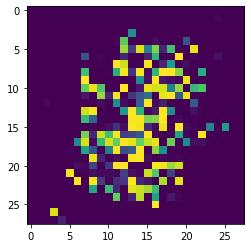

In [ ]:
from matplotlib.pyplot import imshow
fake_data_test = generator(noise(1)).detach()

image_test = fake_data_test.cpu().numpy()
img = np.reshape(image_test,(28,28))
imshow(img)
print(noise(1))